In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [86]:
# Load CSV file
df = pd.read_csv('C:/Git_Repos/POSDV_Streamlit/cardiotocography/raw_data.CSV', delimiter=';')
df.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Variab10.txt,01.12.1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,03.05.1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,03.05.1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,03.05.1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


In [87]:
# clean data
# Extract relevant columns
columns = [
    'LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 
    'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 
    'Variance', 'Tendency', 'NSP'
]

# Filter the dataset to include only these columns
data_filtered = df[columns]

data_filtered.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
2,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
3,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
4,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0


In [88]:
# Drop rows with missing values
data_filtered = data_filtered.dropna()

# Separate features and target
X = data_filtered.drop('NSP', axis=1)
y = data_filtered['NSP']

# Display the first few rows of the filtered data
data_filtered.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
1,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
2,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
3,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
4,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
5,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [89]:
# Exclude non-numeric columns and the target column
numeric_cols = data_filtered.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop('NSP', errors='ignore')  # Drop target column if present
numeric_df = data_filtered[numeric_cols]

# Calculate mean and standard deviation for each numeric feature
feature_means = numeric_df.mean()
feature_stds = numeric_df.std()

# Display the mean and standard deviation for each feature
print(feature_means)
print(feature_stds)

LB          133.303857
AC            2.722484
FM            7.241298
UC            3.659925
DL            1.570085
DS            0.003293
DP            0.126058
ASTV         46.990122
MSTV          1.332785
ALTV          9.846660
MLTV          8.187629
Width        70.445908
Min          93.579492
Max         164.025400
Nmax          4.068203
Nzeros        0.323612
Mode        137.452023
Mean        134.610536
Median      138.090310
Variance     18.808090
Tendency      0.320320
dtype: float64
LB           9.840844
AC           3.560850
FM          37.125309
UC           2.847094
DL           2.499229
DS           0.057300
DP           0.464361
ASTV        17.192814
MSTV         0.883241
ALTV        18.396880
MLTV         5.628247
Width       38.955693
Min         29.560212
Max         17.944183
Nmax         2.949386
Nzeros       0.706059
Mode        16.381289
Mean        15.593596
Median      14.466589
Variance    28.977636
Tendency     0.610829
dtype: float64


In [102]:
# Generate synthetic data using these statistics for continuous features
np.random.seed(42)
num_samples = 150  # Total number of samples (50 per class)
synthetic_data = {}

for feature in numeric_cols:
    if feature == 'Tendency':
        # Handle the discrete 'Tendency' feature separately
        tendency_values = original_df['Tendency'].values
        synthetic_data[feature] = np.random.choice(tendency_values, num_samples)
    else:
        mean = feature_means[feature]
        std = feature_stds[feature]
        synthetic_data[feature] = np.random.normal(loc=mean, scale=std, size=num_samples)

# Ensure 'MSTV' column has float values
synthetic_data['MSTV'] = np.random.uniform(0, 3, num_samples)

# Ensure 'DS' column has float values between 0 and 1
synthetic_data['DS'] = np.random.uniform(0, 1, num_samples)

# Ensure 'FM' column has float values between 0 and 1
synthetic_data['FM'] = np.random.uniform(0, 1, num_samples)

# For other features which should have integer values, cast them to int
integer_features = ['AC', 'UC', 'DL', 'DP', 'ASTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance']
for feature in integer_features:
    synthetic_data[feature] = np.round(synthetic_data[feature]).astype(int)

synthetic_df = pd.DataFrame(synthetic_data)

# Ensure the 'NSP' column is categorical and balanced
synthetic_df['NSP'] = np.array([1] * 50 + [2] * 50 + [3] * 50)

# Check the first few rows of the synthetic dataframe
print(synthetic_df.head())


           LB  AC        FM  UC  DL        DS  DP  ASTV      MSTV  ALTV  ...  \
0  138.191944   4  0.056881   3   3  0.130974   0    36  1.251580   -12  ...   
1  131.943220   4  0.766527   6  -1  0.605997   0    54  0.480677   -23  ...   
2  139.677659   0  0.702107   1   4  0.849446   0    55  0.512809    20  ...   
3  148.291757   4  0.331352   5   5  0.044997   1    51  1.254434    24  ...   
4  130.999590   4  0.675663   2   3  0.734151   0    38  2.271849    -1  ...   

   Min  Max  Nmax  Nzeros  Mode  Mean  Median  Variance  Tendency  NSP  
0  150  132     5       0   126   110     144         3       1.0    1  
1   92  187     1       1   140   105     154        43       0.0    1  
2   73  148     2      -1   128   164     167       -13       1.0    1  
3   49  152     7       0   133   141     153        25       1.0    1  
4   40  153     1      -1   165   121     142        54       0.0    1  

[5 rows x 22 columns]


In [108]:
# Separate features and target from the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled[numeric_cols], y_resampled, test_size=0.2, random_state=42)

# Normalize the features using the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_synthetic_scaled = scaler.transform(synthetic_df[numeric_cols])  # Scale the synthetic data

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Convert target to categorical
y_train_categorical = tf.keras.utils.to_categorical(y_train - 1, num_classes=3)
y_test_categorical = tf.keras.utils.to_categorical(y_test - 1, num_classes=3)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Print class weights
print(f"Class weights: {class_weights_dict}")

# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

callback = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the neural network model with dropout layers and L2 regularization
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(X_train_scaled, y_train_categorical, epochs=100, validation_split=0.2, batch_size=32, verbose=1, callbacks=[callback, early_stopping], class_weight=class_weights_dict)

# Display the model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_categorical)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1) + 1  # Convert to original class labels
y_true_classes = np.argmax(y_test_categorical, axis=1) + 1  # Convert to original class labels

# Generate confusion matrix for the test set
cm_test = confusion_matrix(y_true_classes, y_pred_classes)




Class weights: {0: 1.0168970814132103, 1: 0.9895366218236173, 2: 0.993993993993994}
Epoch 1/100


c:\Users\noiri\.conda\envs\brain_tumor\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3754 - loss: 1.2607 - val_accuracy: 0.7082 - val_loss: 1.0454 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5255 - loss: 1.0761 - val_accuracy: 0.7723 - val_loss: 0.8720 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6058 - loss: 0.9590 - val_accuracy: 0.8176 - val_loss: 0.7528 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6637 - loss: 0.8804 - val_accuracy: 0.8327 - val_loss: 0.6429 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6983 - loss: 0.7955 - val_accuracy: 0.8792 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7436 - loss: 0.7260 - val_accuracy: 0.8717 - val_loss: 0.4774 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7853 - loss: 0.6478 - val_a

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,539 (48.98 KB)

 Trainable params: 4,179 (16.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,360 (32.66 KB)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9562 - loss: 0.1975 
Test Loss: 0.2201354056596756, Test Accuracy: 0.9486404657363892
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


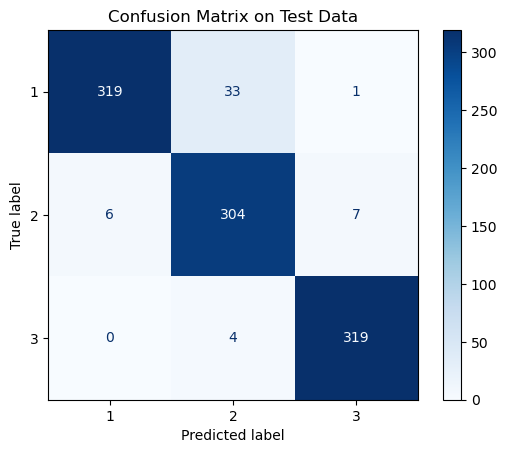

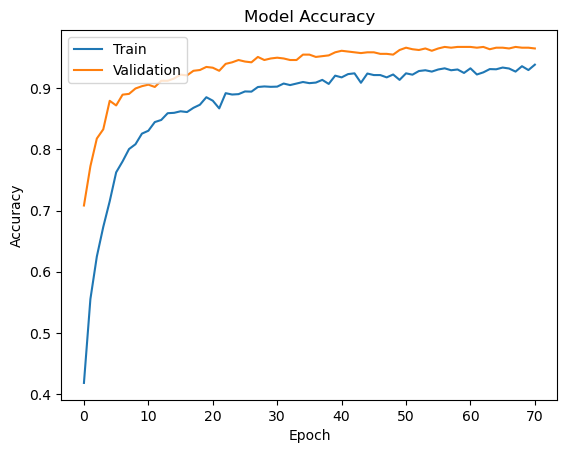

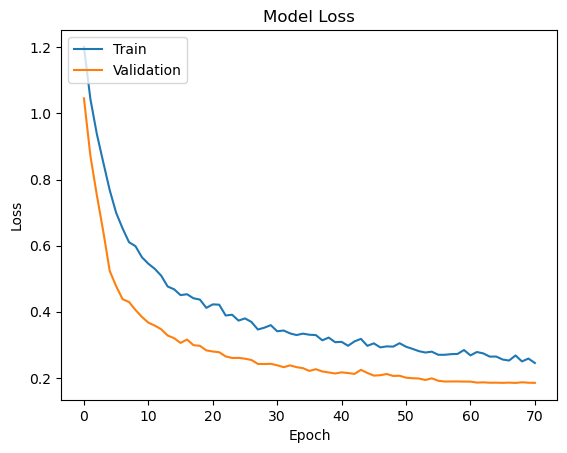

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


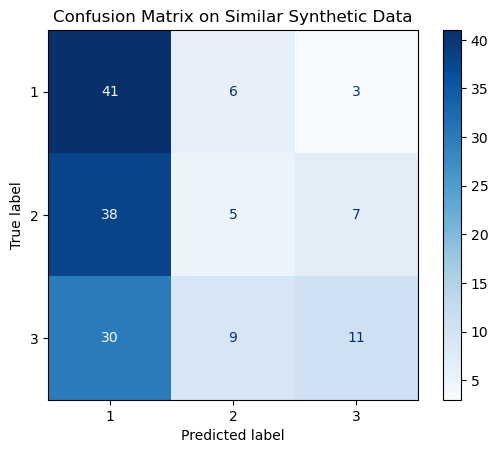

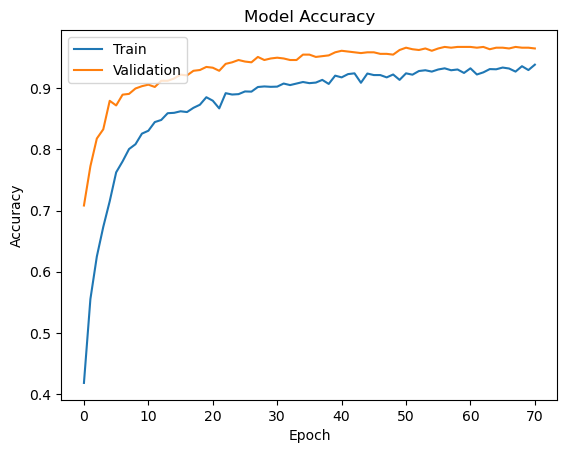

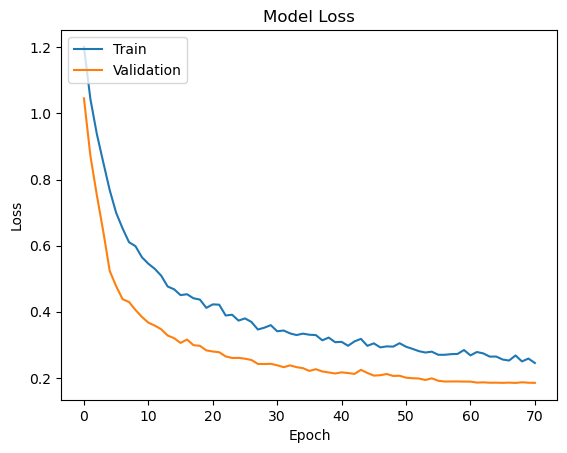

In [109]:
# Display confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[1, 2, 3])
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Data')
plt.show()

# Display accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make predictions on the synthetic data
y_pred_synthetic = model.predict(X_synthetic_scaled)
y_pred_synthetic_classes = np.argmax(y_pred_synthetic, axis=1) + 1  # Convert to original class labels

# Generate confusion matrix for synthetic data
cm_synthetic = confusion_matrix(synthetic_df['NSP'], y_pred_synthetic_classes)

# Display confusion matrix for synthetic data
disp_synthetic = ConfusionMatrixDisplay(confusion_matrix=cm_synthetic, display_labels=[1, 2, 3])
disp_synthetic.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Similar Synthetic Data')
plt.show()

# Display accuracy and loss curves of predictions
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

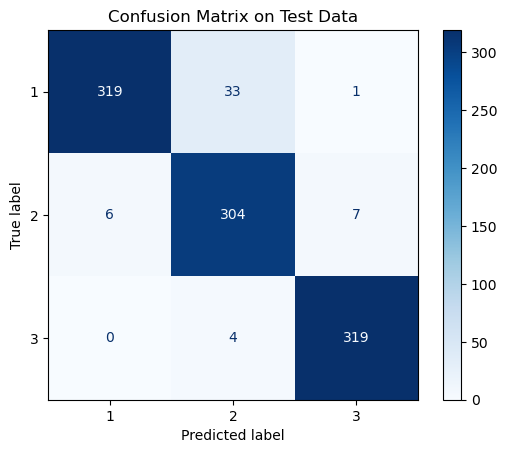

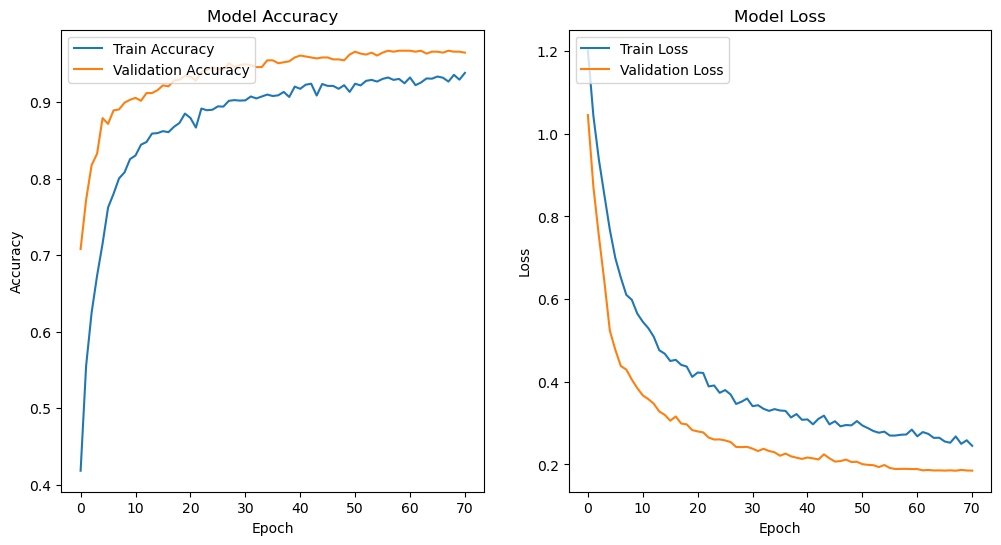

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


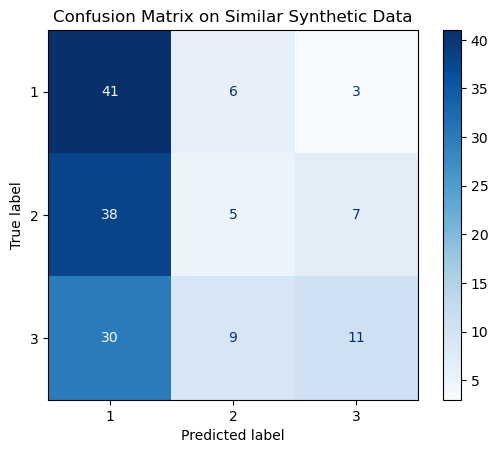

Accuracy on Synthetic Data: 0.38


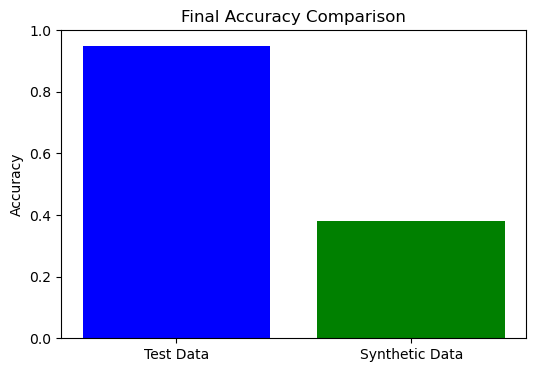

In [112]:
# Display confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[1, 2, 3])
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Data')
plt.show()

# Display accuracy and loss curves for training and validation sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Make predictions on the synthetic data
y_pred_synthetic = model.predict(X_synthetic_scaled)
y_pred_synthetic_classes = np.argmax(y_pred_synthetic, axis=1) + 1  # Convert to original class labels

# Generate confusion matrix for synthetic data
cm_synthetic = confusion_matrix(synthetic_df['NSP'], y_pred_synthetic_classes)

# Display confusion matrix for synthetic data
disp_synthetic = ConfusionMatrixDisplay(confusion_matrix=cm_synthetic, display_labels=[1, 2, 3])
disp_synthetic.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Similar Synthetic Data')
plt.show()

# Calculate accuracy on synthetic data
synthetic_accuracy = np.mean(y_pred_synthetic_classes == synthetic_df['NSP'])
print(f"Accuracy on Synthetic Data: {synthetic_accuracy:.2f}")

# Plot comparison of final accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Test Data', 'Synthetic Data'], [accuracy, synthetic_accuracy], color=['blue', 'green'])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


In [111]:
# Save the entire model to a HDF5 file
model.save('nsp_model.h5')
model.save('nsp_model.keras')
print("Model saved to nsp_model.h5")


Model saved to nsp_model.h5
